In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize

In [2]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    # todo
    
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)       
    img = ds.pixel_array
    img_mean = np.mean(img)
    img_std = np.std(img)
    return (img, img_mean, img_std)
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size): 
    # todo
    # resize the image
    img = resize(img, img_size)

    # standardize the image pixel values.
    proc_img = (img - img_mean)/img_std
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    # todo
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = keras.models.model_from_json(loaded_model_json)
    model.load_weights(weight_path)
    model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    # todo  
    prediction  = model.predict(img)
    if(prediction >=thresh):
        prediction = 1.0
    else:
        prediction = 0.0
    
    return prediction 

(1, 224, 224, 3)


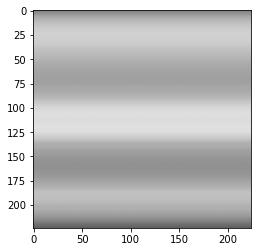

In [6]:
from skimage.transform import resize
x= pydicom.dcmread('test1.dcm')
img = x.pixel_array 
img = resize(img, (1,224,224,3))
print(img.shape)
plt.imshow(img[0])

In [7]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'my_model.json'
weight_path = 'xray_class_my_model.best.hdf5'

IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16
# img_mean = # loads the mean image value they used during training preprocessing
# img_std = # loads the std dev image value they used during training preprocessing

my_model = load_model(model_path, weight_path)
thresh = 0.7144732 #loads the threshold they chose for model classification 

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img, img_mean, img_std = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    print(pred)

Load file test1.dcm ...
0.0
Load file test2.dcm ...
0.0
Load file test3.dcm ...
0.0
Load file test4.dcm ...
0.0
Load file test5.dcm ...
0.0
Load file test6.dcm ...
0.0


#### Some analytics on dicom metadata.

In [13]:
# look at all the info in a dicom file.
x = pydicom.dcmread(test_dicoms[0])
x

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       

In [10]:
metadata = []
for each in test_dicoms:
    dcm = pydicom.dcmread(each)
    fields = [dcm.PatientID, int(dcm.PatientAge), dcm.PatientSex, dcm.Modality, dcm.StudyDescription, dcm.BodyPartExamined,
              dcm.Rows, dcm.Columns]
    metadata.append(fields)
metadata[0]

['2', 81, 'M', 'DX', 'No Finding', 'CHEST', 1024, 1024]

In [12]:
metadf = pd.DataFrame(metadata, 
                      columns = ['PatientID','PatientAge','PatientSex','Modality','Findings','BPE','Rows','Columns'])
metadf

,PatientID,PatientAge,PatientSex,Modality,Findings,BPE,Rows,Columns
0,2,81,M,DX,No Finding,CHEST,1024,1024
1,1,58,M,DX,Cardiomegaly,CHEST,1024,1024
2,61,77,M,DX,Effusion,CHEST,1024,1024
3,2,81,M,DX,No Finding,RIBCAGE,1024,1024
4,2,81,M,CT,No Finding,CHEST,1024,1024
5,2,81,M,DX,No Finding,CHEST,1024,1024


None of the images have Pneumonia as finding(classified by radiologists). Modality of all the images is DX(Digital Radiography). 3 patients all together as patient with ID 2 is tested repetedly. The Body part examined in all the X-rays is Chest.